# Scikit-downscale

## Prepare models

This first cell just imports some libraries and get's things setup for our analysis to come.This first cell just imports some libraries and get's things setup for our analysis to come.

In [1]:
# close warming info
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import numpy as np

from utils import get_sample_data

sns.set(style='darkgrid')

In the cell below, we'll create nine different downscaling models, some from Scikit-downscale and some from Scikit-learn.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation
from skdownscale.pointwise_models import QuantileMappingReressor

models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0),
    'GARD: QuantileMappingRegressor': QuantileMappingReressor()
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')


## Activate CUPs for parallel computing

Step 1: Start a Dask Cluster. Xarray and the `PointWiseDownscaler` will make use of this cluster when it comes time to load input data and train/predict downscaling models. 

In [3]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34386/status,
Dashboard: http://127.0.0.1:34386/status,Workers: 6
Total threads: 24,Total memory: 188.74 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45090,Workers: 6
Dashboard: http://127.0.0.1:34386/status,Total threads: 24
Started: Just now,Total memory: 188.74 GiB
Comm: tcp://146.179.44.35:33244,Total threads: 4
Dashboard: http://146.179.44.35:43461/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:44539,


## Make a choice of the downscale model

In [4]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

# model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
# model = PointWiseDownscaler(RandomForestRegressor(random_state=0))
# model = PointWiseDownscaler(PureAnalog(kind='best_analog', n_analogs=1))
# model = PointWiseDownscaler(PureAnalog(kind='sample_analogs', n_analogs=10))
model = PointWiseDownscaler(QuantileMappingReressor())

model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    QuantileMappingReressor()

## Malaysia/Philippines/Thailand/Indonesia

In [5]:
# parameters
train_slice = slice('2005', '2007')  # train time range   '1981', '1983'
holdout_slice = slice('2053', '2055')  # prediction time range

CITY_CENTER = pd.DataFrame(data={
    'CITY': ['KUALA_LUMPUR','MANILA','BANGKOK','JAKARDA'],
    'LAT' : [3.08  , 14.60 ,13.76 , -6.21 ],
    'LON' : [101.67, 120.99,100.49, 106.81]
                               })
# Malaysia
#NNN,SSS,WWW,EEE = 8.5,-0.5,98.5,120.5

# Philippines
# NNN,SSS,WWW,EEE = 23.5,3.5,115.5,128.5

# Thailand
# NNN,SSS,WWW,EEE = 21.5, 4.5, 96.5, 106.5

# Indonesia
# NNN,SSS,WWW,EEE = 6.5, -12.5, 94.5, 142.5

NNN,SSS,WWW,EEE = CITY_CENTER[CITY_CENTER.CITY=='JAKARDA'].values[0][1]+2, \
                  CITY_CENTER[CITY_CENTER.CITY=='JAKARDA'].values[0][1]-2, \
                  CITY_CENTER[CITY_CENTER.CITY=='JAKARDA'].values[0][2]-2, \
                  CITY_CENTER[CITY_CENTER.CITY=='JAKARDA'].values[0][2]+2

# bounding box of downscaling region
lon_slice = slice(WWW, EEE) 
lat_slice = slice(NNN, SSS)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [6]:
import ee
import wxee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

# singapore: 1.3521° N, 103.8198° E
region = ee.Geometry.Polygon([[
    [WWW, NNN],
    [WWW, SSS],
    [EEE, SSS],
    [EEE, NNN]
]])
era5_2mt = ee.ImageCollection('ECMWF/ERA5/DAILY')
era5_2mt = era5_2mt.select('total_precipitation')
era5_2mt = era5_2mt.filterDate("2005-01-01", "2008-01-01") # here we should add one more time for the end point
obs_subset=era5_2mt.wx.to_xarray(region=region)
obs_subset=obs_subset['total_precipitation']

Enter verification code:  4/1AX4XfWg61aKkHUl0M6pRnkWfIgdUElxfp4CyeFwKp6l70prFyPO75ydVoyk



Successfully saved authorization token.


Requesting data:   0%|          | 0/1095 [00:00<?, ?it/s]

xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Rlj2_jqOrQqhwiBF3_7zwQNTWqOpIdqLfCbbovfkQcc&code_challenge_method=S256'


In [7]:
obs_subset=obs_subset.rename({'x': 'lon','y': 'lat'})

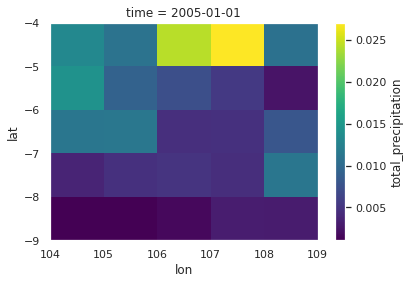

In [8]:
obs_subset.isel(time=0).plot()

Set the downscale resolution here. Example: CHANGE_INTERVAL=0.02 is for a resolution of 1deg*0.02~2km

In [9]:
CHANGE_INTERVAL=0.01#0.005
obs_subset = obs_subset.interp(lat=np.arange(NNN, SSS-CHANGE_INTERVAL,-CHANGE_INTERVAL),lon=np.arange(WWW, EEE+CHANGE_INTERVAL,CHANGE_INTERVAL),kwargs={"fill_value": "extrapolate"})
# obs_subset.interp(lat=np.arange(NNN, SSS-CHANGE_INTERVAL,-CHANGE_INTERVAL),lon=np.arange(WWW, EEE+CHANGE_INTERVAL,CHANGE_INTERVAL)).isel(time=0).plot()

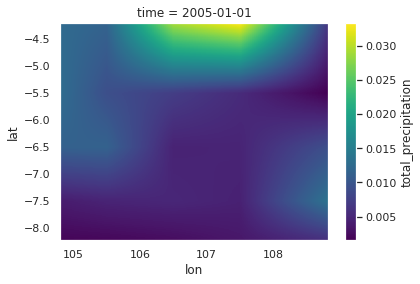

In [10]:
obs_subset.isel(time=0).plot()

Load our training/prediction data.

,Array,Chunk
Bytes,675.04 MiB,427.73 kiB
Shape,"(1095, 402, 402)","(1095, 10, 10)"
Count,3362 Tasks,1681 Chunks
Type,float32,numpy.ndarray


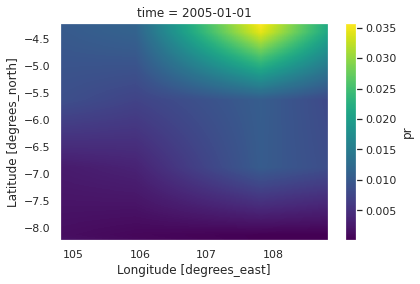

In [11]:
import intake_esm
import intake

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
################################################################
# change the member_id from r1i1p1f1 for temp to r3i1p1f1 for pr
################################################################
cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='pr',member_id='r3i1p1f1',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['pr'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
# train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# access the data and do some cleanup
ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

holdout_subset = ds_model['pr'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
# holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# convert the unit of pr in CMIP from kg m2 s-1 to m as in ERA5, * 86.4
train_subset   = train_subset   * 86.4
holdout_subset = holdout_subset * 86.4

# display
# display(train_subset)
# train_subset.isel(time=0).plot()
display(train_subset)
train_subset.isel(time=0).plot()

Check the available CMIP6 models

In [12]:
import intake_esm
import intake
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='pr',grid_label='gn',institution_id='CSIRO-ARCCSS')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,day,pr,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r2i1p1f1,day,pr,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191125
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r2i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20200303
3,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r3i1p1f1,day,pr,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20200306
4,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r3i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20200428
5,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20210317
6,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r5i1p1f1,day,pr,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20210607
7,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r4i1p1f1,day,pr,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20210607
8,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r4i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20210712
9,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r5i1p1f1,day,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,NaN,20210802


Train the model

In [13]:
model.fit(train_subset, obs_subset)
# model.fit(train_subset, train_subset)
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    QuantileMappingReressor()

<xarray.DataArray 'pr' (lat: 402, lon: 402)>
dask.array<<this-array>-_fit_wrapper, shape=(402, 402), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -4.21 -4.22 -4.23 -4.24 ... -8.19 -8.2 -8.21 -8.22
  * lon      (lon) float64 104.8 104.8 104.8 104.8 ... 108.8 108.8 108.8 108.8

Downscale into future

In [14]:
predicted = model.predict(holdout_subset).load()
nowdays = model.predict(train_subset).load()

In [15]:
predicted.to_netcdf("./OUTPUT/RAIN_JAKARDA_1km_2050.nc")
nowdays  .to_netcdf("./OUTPUT/RAIN_JAKARDA_1km_NOW.nc")

## PLOT

In [16]:
# modified from

import regionmask
import geopandas as gpd

PATH_TO_SHAPEFILE = '../../borders/gadm36.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

In [ ]:
import xarray as xr
from   mpl_toolkits.basemap    import Basemap
from   matplotlib              import gridspec
from   matplotlib.colorbar     import Colorbar


fig,ax=plt.subplots(1,1); fig.set_size_inches(7,5); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(300); 
fig.subplots_adjust(left=0.00, right=0.95, top=1., bottom=0.0, wspace=0.4,hspace=0.3); fontsize = 8

gs0  = gridspec.GridSpec(1, 1)
gs0.update(left=0.97, right=0.99, bottom=0.00, top=1., hspace=0.06, wspace=0.1)
bx = plt.subplot(gs0[0, 0])

m = Basemap(projection='cyl', llcrnrlat=-11, urcrnrlat=21,llcrnrlon=94, urcrnrlon=142,resolution='i',ax=ax)
_ = m.drawcoastlines(linewidth=.5,color='k',zorder=10)
_ = m.drawcountries(linewidth=.5,color='m',zorder=10)
_ = m.drawmapboundary(fill_color='w')
_ = m.fillcontinents(color='none',lake_color='none')
_ = m.drawmeridians(np.arange(0,361,5),labels=[0,0,0,1],linewidth=0.,fontsize=fontsize)
_ = m.drawparallels(np.arange(-40,61,5),labels=[1,0,0,0],linewidth=0.,fontsize=fontsize)

C_NAME = 'JAKARDA'
COUNTRY = 'Indonesia'   #'Malaysia','Philippines','Thailand','Indonesia'

    
predicted = xr.open_dataset('./OUTPUT/RAIN_'+C_NAME+'_1km_2050.nc')
nowdays   = xr.open_dataset('./OUTPUT/RAIN_'+C_NAME+'_1km_NOW.nc')

countries_select = countries[countries.NAME_0==COUNTRY].geometry

countries_mask_poly = regionmask.Regions(name = 'NAME_0', outlines = list(countries_select.geometry.values[i] for i in range(0,countries_select.shape[0])))

mask = countries_mask_poly.mask(predicted.isel(time = 0), lat_name='lat', lon_name='lon')

# tmp_var = predicted.mean('time')-nowdays.mean('time')
tmp_var = predicted.quantile(0.99, dim="time")-nowdays.quantile(0.99, dim="time")
### we can smooth the quantilet but will lose details
# for SMOOTH in range(1):
#     tmp_var = tmp_var.rolling(lat=10,lon=10, center=True, min_periods=1).mean()
tmp_var = tmp_var.where(~np.isnan(mask))

# change unit from m to mm
tmp_var = tmp_var * 1000.

c=tmp_var.__xarray_dataarray_variable__.plot(ax=ax,cmap='RdBu',levels=np.linspace(-3,3,21),extend='both',add_colorbar=False,facecolor="white")
if C_NAME == 'Malaysia':
    cb = Colorbar(ax = bx, mappable = c,orientation = 'vertical', ticklocation = 'right')
    cb.set_label('Precipitation in 2050 (mm per day)', labelpad=5,fontsize=fontsize)
    cb.ax.tick_params(labelsize=fontsize)        

_=countries_select.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 0.)
_=ax.set_xlim(94,142)
_=ax.set_ylim(-11,21)
_=ax.set_xlabel('')
_=ax.set_ylabel('')

